In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress as lnrg

In [3]:
Spreadsheetname = input('Enter name of the spreadsheet: ')
Spreadsheet_name = f'{Spreadsheetname}.xlsx'

Enter name of the spreadsheet: Reformatted


In [4]:
Isotherms_name = input('Enter the name of the isotherms sheet: ')
Kinetics_name = input('Enter the name of the kinetics sheet: ')

Enter the name of the isotherms sheet: Muedi Isotherms
Enter the name of the kinetics sheet: Muedi Kinetics


In [33]:
no1 = int(input('How many temperatures were used in the isotherm experiments: '))

How many temperatures were used in the isotherm experiments: 3


In [34]:
Tspan = []
for i in range(no1):
    t = int(input(f'Insert T{i+1} here (in K): '))
    Tspan.append(t)

Insert T1 here: 298
Insert T2 here: 308
Insert T3 here: 318


In [35]:
no2 = int(input('How many initial concentration runs were done in the kinetics experiments: '))

How many initial concentration runs were done in the kinetics experiments: 4


In [36]:
Cspan = []
for i in range(no2):
    c = int(input(f'Insert C{i+1} here (in mg/L): '))
    Cspan.append(c)

Insert C1 here: 10
Insert C2 here: 150
Insert C3 here: 200
Insert C4 here: 250


In [37]:
m = float(input('Enter the mass of adsorbent used in the kinetics study (in g): '))
V = float(input('Enter the volume of the adsorbate solution used in the kinetics (in L): '))

Enter the mass of adsorbent used in the kinetics study (in g): 1
Enter the volume of the adsorbate solution used in the kinetics (in L): 0.25


In [38]:
T_kinetics = float(input('Enter the temperature used for the kinetics study (in K): '))

Enter the temperature used for the kinetics study: 298.15


In [39]:
Timevar = input('Does each kinetics data set have its own individual time set ("Yes")? (If one universal set, enter "No"): ')

Does each kinetics data set have its own individual time set ("Yes")? (If one universal set, enter "No"): no


In [40]:
Time_units = input('What units are the time values in: ')

What units are the time values in: min


In [41]:
T_range = np.array(Tspan)
C_array = np.array(Cspan)

if Timevar == 'Yes' or 'yes':
    No_TimeVar = 0
if Timevar == 'No' or 'no':
    No_TimeVar = 1
    
R = 8.314
T_forcalc = T_kinetics
T_used = T_forcalc

percenta = 0

In [42]:
if len(T_range) == 1:
    no_Tvar = 1
    
else:
    no_Tvar = 0

In [43]:
iso = pd.read_excel(Spreadsheet_name, sheet_name = Isotherms_name)
for i in range(1, no1+1):
    gr = f'Ce{i}'
    gt = f'{T_range[i-1]}K'
    locals()[gr] = np.array(iso[gr])
    locals()[gt] = np.array(iso[gt])
    
for j in range(1, no1+1):
    tf = f'Ce{j}'
    ty = f'Ce_{j}'
    locals()[ty] = locals()[tf][~np.isnan(locals()[tf])]
    
    hg = f'{T_range[j-1]}K'
    gh = f'Qe_{T_range[j-1]}'
    locals()[gh] = locals()[hg][~np.isnan(locals()[hg])]

In [44]:
Ce_list = []
Qe_list = []

for i in range(1, no1+1):
    skrt = f'Ce_{i}'
    fgrt = f'Qe_{T_range[i-1]}'
    Ce_list.append(locals()[skrt])
    Qe_list.append(locals()[fgrt])

In [45]:
Cetotal = []
Qetotal = []
b = []
c = []
for j in range(no1):
    result = Ce_list[j]
    qq = Qe_list[j]
    Cetotal = np.append(b, result)
    Qetotal = np.append(c, qq)
    if j == no1-1:
        break
    else:
        b = Cetotal
        c = Qetotal

In [46]:
jk = []
for i in range(len(Ce_list)):
    jk.append(len(Ce_list[i]))

kj = []
kj.append(0)
summ = 0
for i in range(len(jk)):
    summ += jk[i]
    kj.append(summ)

In [47]:
b_vals = []
qm_vals = []

for i in range(no1):
    ff = f'Qe_{T_range[i]}'
    dd = f'Ce_{i+1}'
    
    xvals = 1/locals()[dd][1:]
    yvals = 1/locals()[ff][1:]
    
    bqm_1, Qm_1 = np.polyfit(xvals, yvals, 1)
    Qm = 1/Qm_1
    b = (1/bqm_1)/Qm
    
    b_vals.append(b)
    qm_vals.append(Qm)
    
qm_guess = np.sum(qm_vals)/no1

if no_Tvar == 1:
    kL_guess = np.sum(np.array(b_vals))/no1

else:
    lnb = np.log(np.array(b_vals))
    neg_hr, sr = np.polyfit(1/T_range, lnb, 1)

    s_guess = sr*R
    h_guess = neg_hr*R*-1

In [48]:
if no_Tvar == 1:
    def comboFunc(comboData, kL, Qmax):        
        b = []

        for j in range(no1):
            def isotherm(Ce, kL, Qmax):
                T = T_range[j]
                Qe = (kL*Qmax*Ce)/(1+kL*Ce)
                return Qe

            extract = comboData[kj[j]:kj[j+1]]
            result = isotherm(extract, kL, Qmax)

            a = np.append(b, result)
            if j == (no1-1):
                break
            else:
                b = a
        return a

    initialParameters = np.array([kL_guess, qm_guess])
    fittedParameters, pcov = curve_fit(comboFunc, Cetotal, Qetotal, initialParameters)

    kL, Qmax = fittedParameters

    C_range = np.linspace(0, max(Cetotal), 101)
    
    def isotherm_plot(Ce, kL, Qmax, T):
        Qe = (kL*Qmax*Ce)/(1+kL*Ce)
        return Qe
    
else:
    def comboFunc(comboData, S, H, Qmax):        
        b = []

        for j in range(no1):
            def isotherm(Ce, S, H, Qmax):
                T = T_range[j]
                kL = np.exp(S/R - (H)/(R*T))
                Qe = (kL*Qmax*Ce)/(1+kL*Ce)
                return Qe

            extract = comboData[kj[j]:kj[j+1]]
            result = isotherm(extract, S, H, Qmax)

            a = np.append(b, result)
            if j == (no1-1):
                break
            else:
                b = a
        return a

    initialParameters = np.array([s_guess, h_guess, qm_guess])
    fittedParameters, pcov = curve_fit(comboFunc, Cetotal, Qetotal, initialParameters)

    S, H, Qmax = fittedParameters

    C_range = np.linspace(0, max(Cetotal), 101)

    def isotherm_plot(Ce, S, H, Qmax, T):
        kL = np.exp(S/R - (H)/(R*T))
        Qe = (kL*Qmax*Ce)/(1+kL*Ce)
        return Qe

In [49]:
if no_Tvar == 1:
    pass
else:
    kL = np.exp(S/R - H/(R*T_forcalc))

In [50]:
if no_Tvar == 1:
    Qe_final = isotherm_plot(C_range, kL, Qmax, T_used)[-1]
    
else:
    Qe_final = isotherm_plot(C_range, S, H, Qmax, T_used)[-1]

In [51]:
kin = pd.read_excel(Spreadsheet_name, sheet_name = Kinetics_name)
for i in range(no2):
    gr = f'{C_array[i]} ppm'
    ty = f'ppm_{C_array[i]}'
    locals()[ty] = np.array(kin[gr])
    locals()[ty] = locals()[ty][~np.isnan(locals()[ty])]
    
    if No_TimeVar == 1:
        Time = np.array(kin['Experimental time'])
        
    else:
        ge = f'Time{C_array[i]}'
        te = f'Time_{C_array[i]}'
        locals()[te] = np.array(kin[ge])
        locals()[te] = locals()[te][~np.isnan(locals()[te])]

In [52]:
T_list = []
Q_list = []

if No_TimeVar == 1:
    for i in range(no2):
        fgrt = f'ppm_{C_array[i]}'
        T_list.append(Time)
        Q_list.append(locals()[fgrt])
        
else:
    for i in range(no2):
        fgrt = f'ppm_{C_array[i]}'
        flp = f'Time_{C_array[i]}'
        T_list.append(locals()[flp])
        Q_list.append(locals()[fgrt])

In [53]:
if percenta == 1:
    Q_list = np.array(Q_list)
    Q_list = Q_list/100*Qe_final
    
else:
    pass

In [54]:
Ttotal = []
Qtotal = []
gg = []
rr = []
for j in range(no2):
    result = T_list[j]
    qq = Q_list[j]
    Ttotal = np.append(gg, result)
    Qtotal = np.append(rr, qq)
    if j == no2-1:
        break
    else:
        gg = Ttotal
        rr = Qtotal

In [55]:
jj = []
for i in range(len(T_list)):
    jj.append(len(T_list[i]))
    
kk = []
kk.append(0)
summ = 0
for i in range(len(jj)):
    summ += jj[i]
    kk.append(summ)

In [56]:
kad_vals = []

for i in range(no2):
    xvals = T_list[i][0:2]
    yvals = np.log(Qe_final - Q_list[i][0:2])
    
    slope, intercept = np.polyfit(xvals, yvals, 1)
    k1 = - slope
    
    kad = (k1*Qe_final/(C_array[i]))
    kad_vals.append(kad)
    
kad_vals = np.array(kad_vals)
kad_guess = np.sum(kad_vals/no2)

In [57]:
def comboFunc22(comboData, kad):
        
    b = []
        
    for j in range(no2):
        
        times = comboData[kk[j]:kk[j+1]]
        
        def kinetics(t, kad):
            def inte(t, var):
                Q = var
                Ca0 = C_array[j]
                Ca = Ca0 - Q*(m/V)
                dQdt = kad*Ca*(1 - Q/Qmax) - (kad/kL)*(Q/Qmax)
                return dQdt
            
            ts = (0, t[-1])
            ans = solve_ivp(inte, ts, [0], t_eval = times)
            Qt = ans.y[0]

            return Qt
        
        result = kinetics(times, kad)
        
        a = np.append(b, result)
        if j == (no2-1):
            break
        else:
            b = a
    return a

initialParameters = np.array([kad_guess])
fittedParameters, pcov = curve_fit(comboFunc22, Ttotal, Qtotal, initialParameters)

kad = fittedParameters[0]

Qmax = 101.927 mg/g
S = 15.504 J/(mol*K)
H = 6344.828 J/mol


kad = 0.02014 L/(g*min)


R_squared = 0.996
STDerror = 0.014




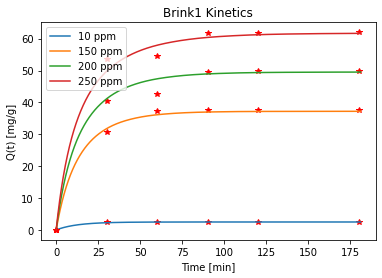

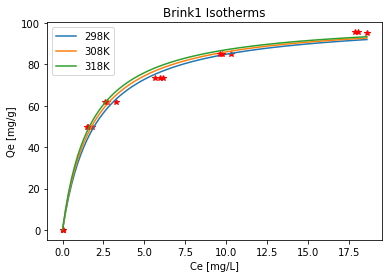

In [58]:
Qlist_new = []

for k in range(no2):

    def kinetics(t, kad):    
        def inte(t, var):
            Q = var
            Ca0 = C_array[k]
            Ca = Ca0 - Q*(m/V)
            dQdt = kad*Ca*(1 - Q/Qmax) - (kad/kL)*(Q/Qmax)
            return dQdt

        ts = (0, t[-1])
        ans = solve_ivp(inte, ts, [0], dense_output = True)

        Qt = ans.sol(t)[0]
        return Qt
    
    Tf = int(np.round(T_list[j][-1]+1, 0))
    Tspan1 = np.linspace(0, Tf, Tf*10+1)
    
    plt.figure(1)
    plt.plot(T_list[k], Q_list[k], 'r*')
    plt.plot(Tspan1, kinetics(Tspan1, kad), label = f'{C_array[k]} ppm')
    
    Qlist_new.append(kinetics(T_list[k], kad))
    
Qtot_new = []
emt = []
for j in range(no2):
    result = Qlist_new[j]
    Qtot_new = np.append(emt, result)
    if j == no2-1:
        break
    else:
        emt = Qtot_new
        
slope, intercept, r_val, p_val, std_error = lnrg(Qtotal, Qtot_new)

plt.figure(1)
plt.legend()
plt.xlabel(f'Time [{Time_units}]')
plt.ylabel(f'Q(t) [mg/g]')
plt.title(Kinetics_name)

if no_Tvar == 1:
    plt.figure(2)
    plt.plot(Ce_1, Qe_list[0], 'r*')
    plt.plot(C_range, isotherm_plot(C_range, kL, Qmax, T_range[0]), label = f'{T_range[0]}K')
    
else:
    plt.figure(2)
    for i in range(no1):
        plt.plot(Ce_list[i], Qe_list[i], 'r*')
        plt.plot(C_range, isotherm_plot(C_range, S, H, Qmax, T_range[i]), label = f'{T_range[i]}K')
        
plt.figure(2)
plt.legend()
plt.xlabel('Ce [mg/L]')
plt.ylabel('Qe [mg/g]')
plt.title(Isotherms_name)

print(f'Qmax = {np.round(Qmax, 3)} mg/g')
if no_Tvar == 1:
    print(f'kL = {np.round(kL, 5)} L/(g*{Time_units})')
else:
    print(f'S = {np.round(S, 3)} J/(mol*K)')
    print(f'H = {np.round(H, 3)} J/mol')
print('\n')
print(f'kad = {np.round(kad, 5)} L/(g*{Time_units})')
print('\n')
print(f'R_squared = {np.round(r_val**2, 3)}')
print(f'STDerror = {np.round(std_error, 3)}')
print('\n')